In [1]:
import sys
print(sys.executable)

c:\Users\kbw82\Desktop\2024-DSAIL-Lab-Intern\labenv\Scripts\python.exe


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.12.1+cu113
11.3


c:\Users\kbw82\Desktop\2024-DSAIL-Lab-Intern\labenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [4]:
from torch_geometric.datasets import KarateClub, CoraFull, Planetoid

dataset = KarateClub()
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [5]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [6]:
# For subgraph formation
# node_indices = torch.arange(0,30)  

# new_edge_index, edge_mask = subgraph(node_indices, data.edge_index, relabel_nodes=True)

# sub_data = Data(x=data.x[node_indices], edge_index=new_edge_index)
# if data.edge_attr is not None:
#     sub_data.edge_attr = data.edge_attr[edge_mask]
# if data.y is not None:
#     sub_data.y = data.y[node_indices]

# data = sub_data

In [7]:
data.edge_index.T

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

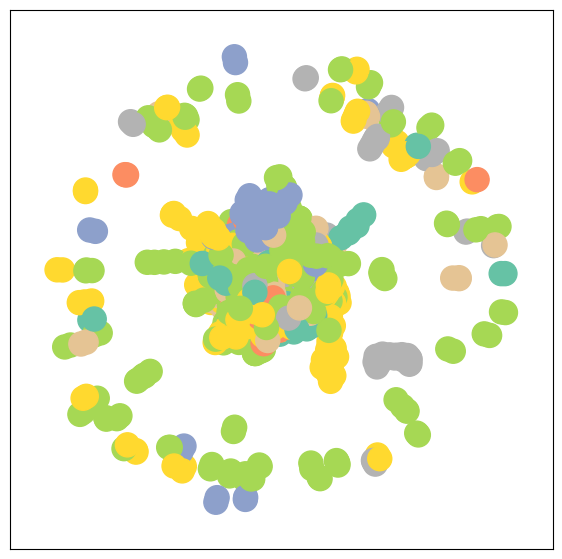

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [9]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 256)
        self.conv2 = GCNConv(256, 64)
        self.conv3 = GCNConv(64, 16)
        # 마지막에 Linear transformation 추가해도 되고 안해도 됨 --> 안할 시에는 GCNConv 의 마지막 output dim이 num_classes가 되도록
        self.classifier = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1433, 256)
  (conv2): GCNConv(256, 64)
  (conv3): GCNConv(64, 16)
  (classifier): Linear(in_features=16, out_features=7, bias=True)
)


Embedding shape: [2708, 16]


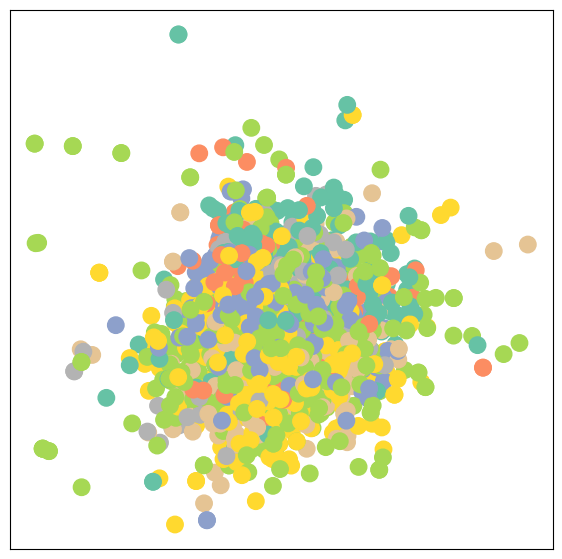

In [10]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [12]:
data.train_mask
out, h = model(data.x, data.edge_index)
out

tensor([[-0.2811,  0.1256,  0.0481,  ...,  0.0141, -0.1160,  0.0400],
        [-0.2666,  0.2158,  0.2188,  ..., -0.0441, -0.0737,  0.0100],
        [-0.3116,  0.1746,  0.2142,  ..., -0.0933, -0.0833,  0.0326],
        ...,
        [-0.2622,  0.1958,  0.1205,  ..., -0.0910, -0.1502,  0.0552],
        [-0.2287,  0.2580,  0.1012,  ..., -0.0506, -0.1885, -0.0065],
        [-0.2421,  0.2358,  0.0964,  ..., -0.0479, -0.1696, -0.0108]],
       grad_fn=<AddmmBackward0>)

In [13]:
torch.argmax(out[data.train_mask], axis=1)

tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 6, 1, 1, 1, 2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<IPython.core.display.Javascript object>

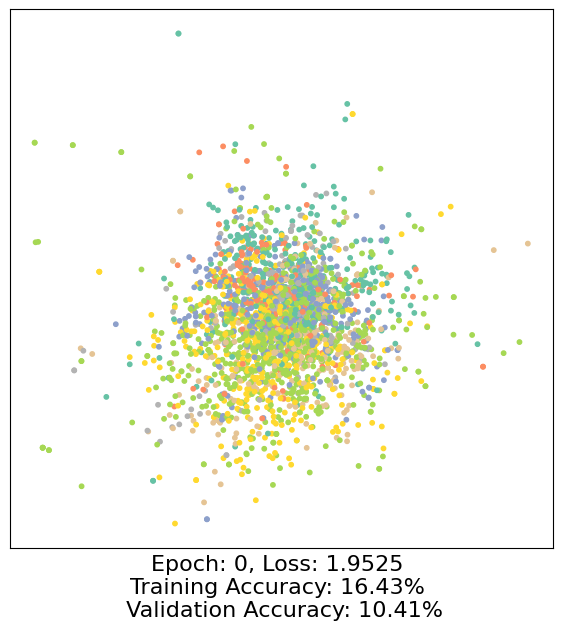

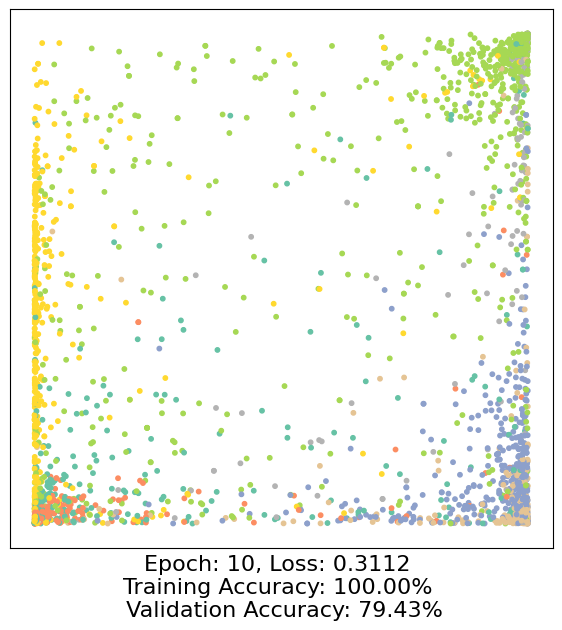

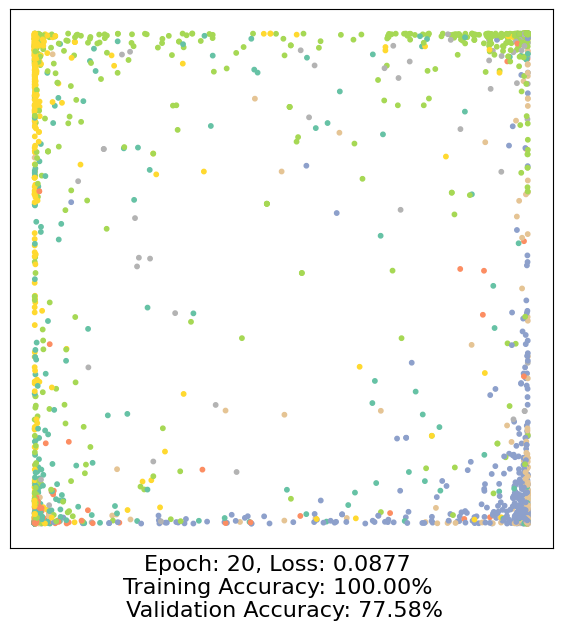

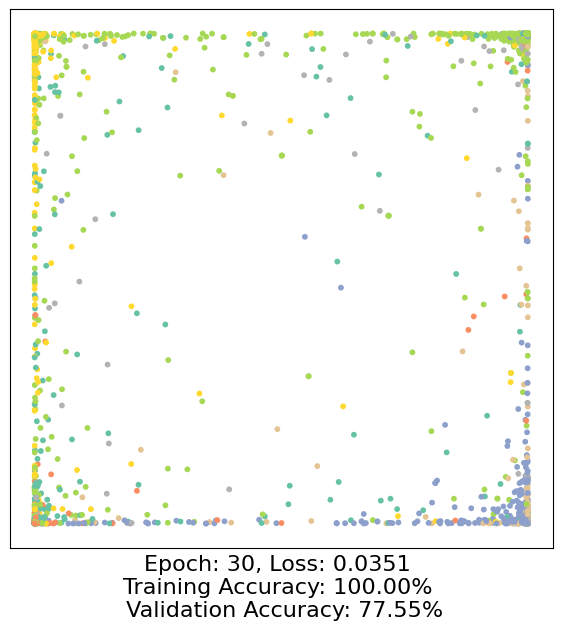

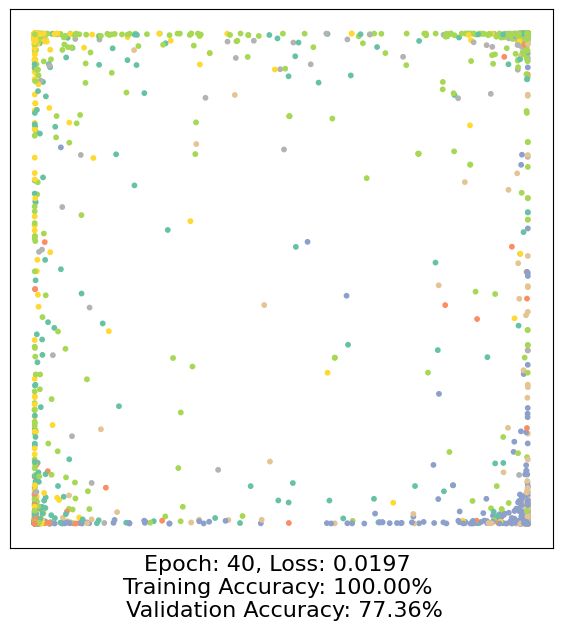

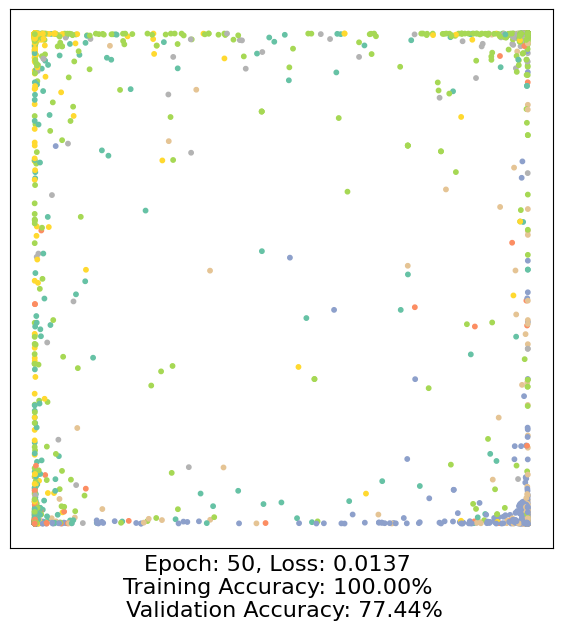

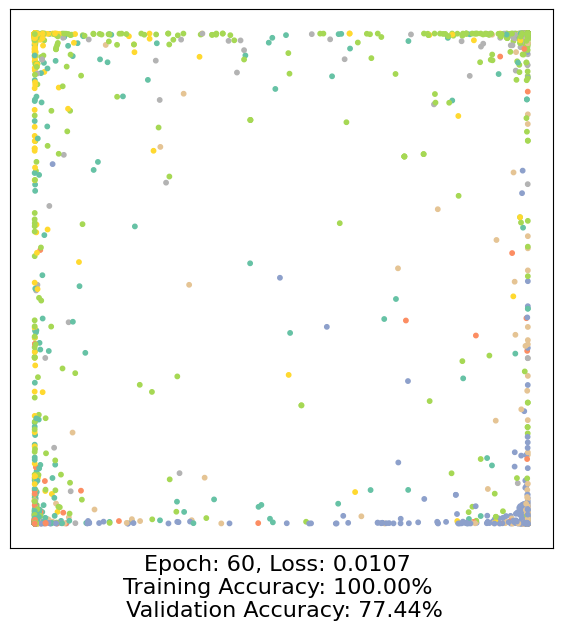

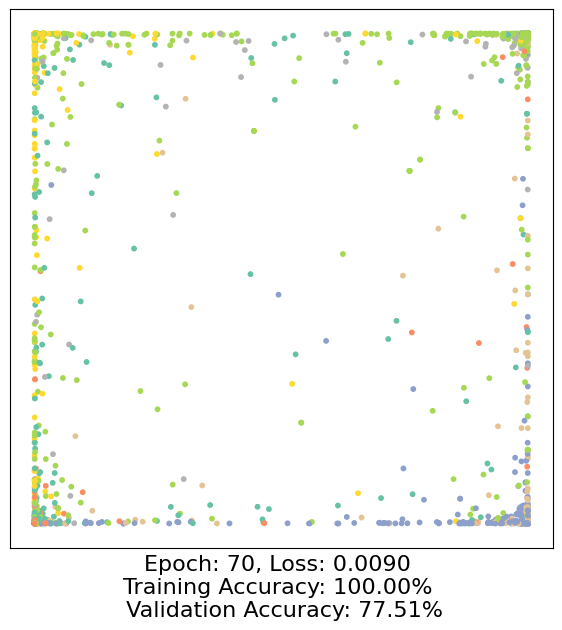

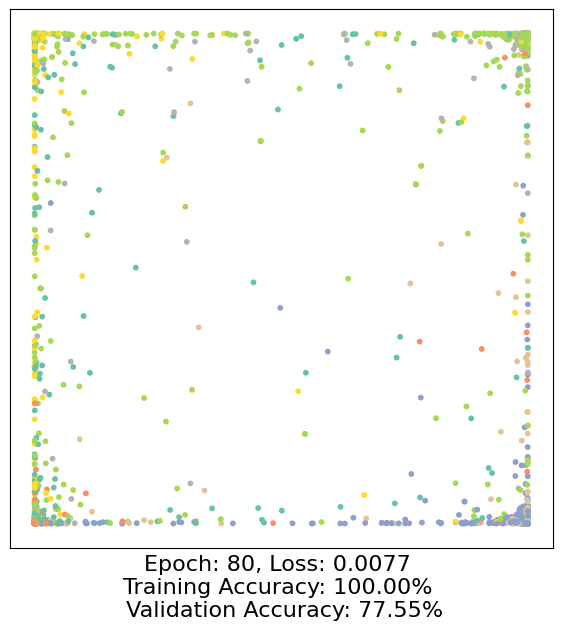

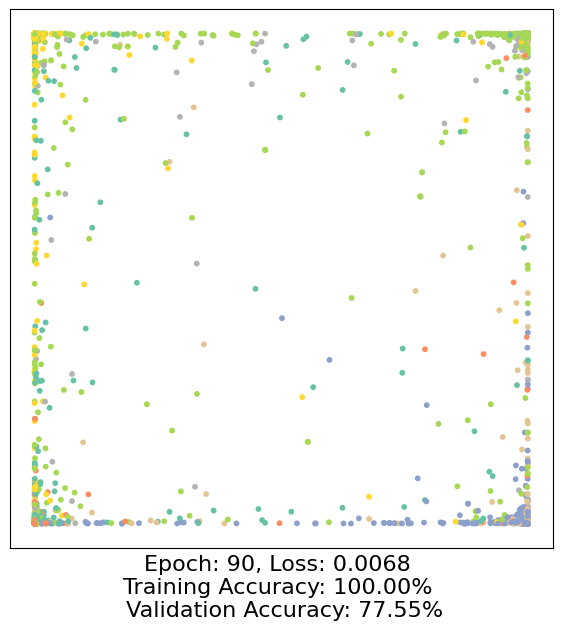

In [32]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(100):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)